In [52]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA

# Training

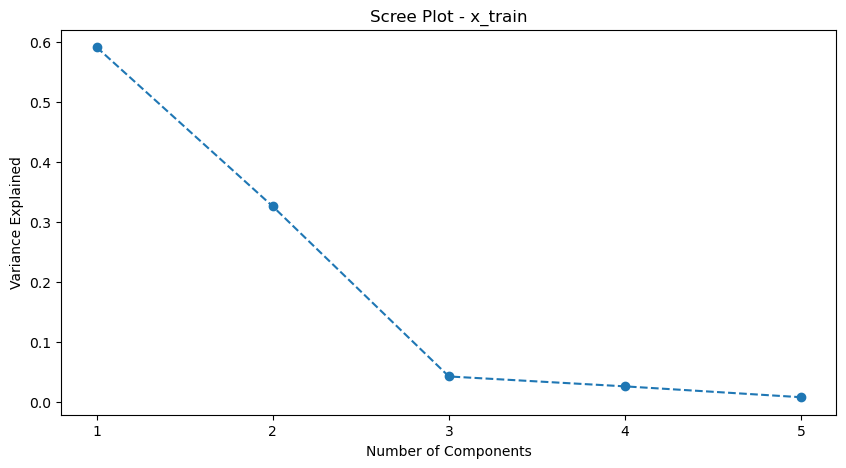

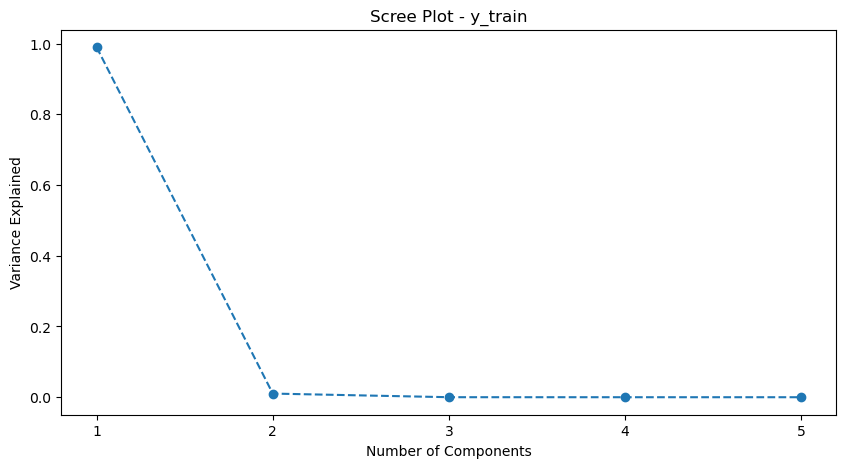

In [53]:
# Display?
display_subset = False
how_many = 5
####################

# Parameters
n_features = 1000
n_targets = n_features

n_samples_V_train = 100
n_samples_H_0_train = 100
v_range_train = (1, 10)
H_0_range_train = (1, 10)

x_range = (-30, 30)
####################

x = np.linspace(x_range[0], x_range[1], n_features)

rng = np.random.default_rng(seed=99)
V_arr_train = np.random.uniform(v_range_train[0], v_range_train[1], n_samples_V_train)
H_0_arr_train = np.random.uniform(H_0_range_train[0], H_0_range_train[1], n_samples_H_0_train)

train_params = np.array(list(itertools.product(V_arr_train, H_0_arr_train)))
n_samples_train = train_params.shape[0]

x_train = np.zeros((n_samples_train, n_features))
y_train = np.zeros((n_samples_train, n_targets))

for i, params in enumerate(train_params):
    x_train[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])
    y_train[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])

    if (i+1) % int(n_samples_train/how_many) == 0 and display_subset:
        print(f'{i+1}/{n_samples_train}: V = {params[0]}, H_0 = {params[1]}')
        plt.figure()
        plt.plot(x, x_train[i, :], label='x_train')
        plt.plot(x, y_train[i, :], label='y_train')
        plt.legend()
        plt.show()

# determine number of components to keep for x_train and y_train
        
x_pca = PCA(n_components=5)
y_pca = PCA(n_components=5)
x_lowdim = x_pca.fit_transform(x_train)
y_lowdim = y_pca.fit_transform(y_train)

x_explained_variance = x_pca.explained_variance_ratio_
y_explained_variance = y_pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(x_explained_variance) + 1), x_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - x_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(x_explained_variance) + 1))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_explained_variance) + 1), y_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - y_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(y_explained_variance) + 1))
plt.show()

In [54]:
low_dim_x = 3
low_dim_y = 1
GP_params = {'kernel': gpx.kernels.RBF(), 'mean_function': gpx.mean_functions.Zero()}

reg = first_model(low_dim_x=low_dim_x, low_dim_y=low_dim_y, low_dim_regressor='linear')
reg.fit(x_train, y_train, save=True)

print(reg.low_dim_regressor_list)

(10000, 3)
(10000, 1)
linear
(10000, 1)
(10000, 1)
[LinearRegression()]


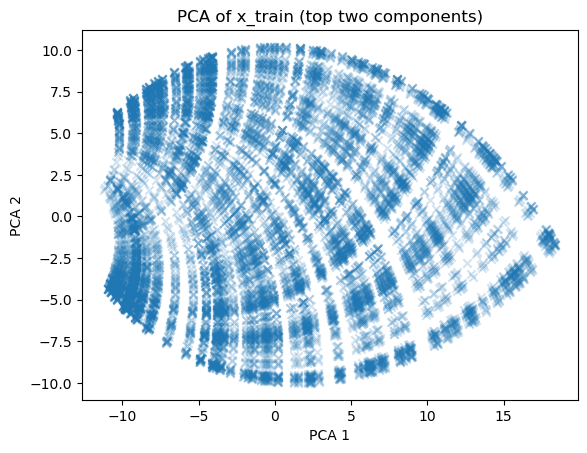

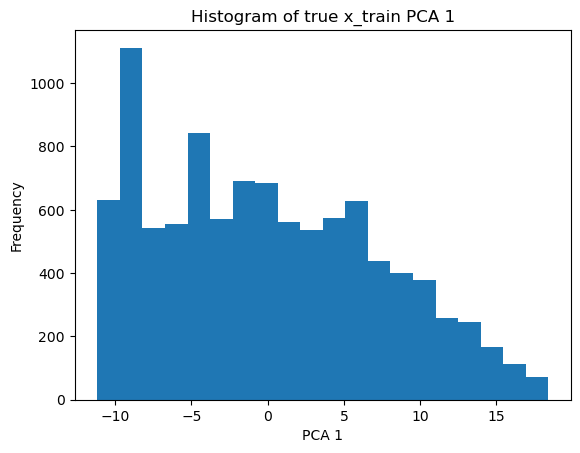

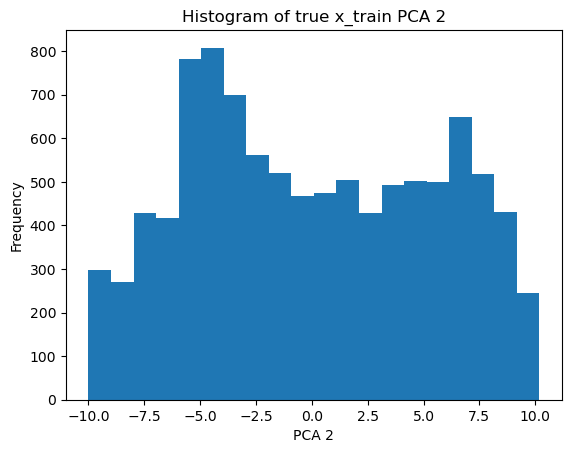

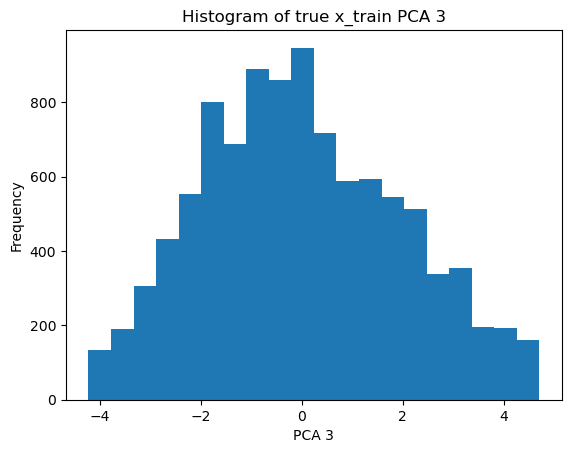

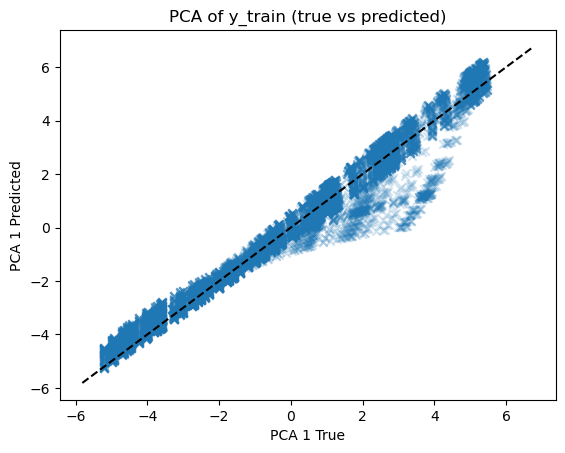

MSE: 0.3140077973449663
Correlation: 0.9815536541697389


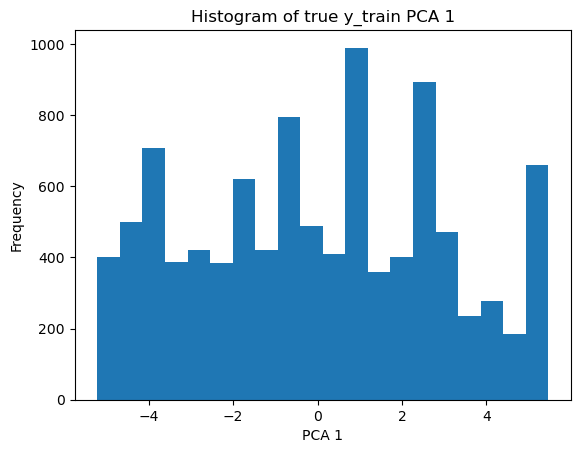

In [55]:
# assess how well the low-dimensional regression is doing

if low_dim_x > 1:
    plt.figure()
    plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of x_train (top two components)')
    plt.show()
if low_dim_x == 1:
    for i in range(low_dim_y):
        plt.figure()
        plt.scatter(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim[:, i], marker='x', alpha=0.2)
        plt.plot(reg.X_train_low_dim[:, 0], reg.low_dim_regressor_list[i].predict(reg.X_train_low_dim), color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        plt.xlabel('x_train PCA 1')
        plt.ylabel(f'y_train PCA {i+1}')
        plt.show()

for i in range(low_dim_x):
    plt.figure()
    plt.hist(reg.X_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true x_train PCA {i+1}')
    plt.show()


for i in range(low_dim_y):
    plt.figure()
    ax = plt.gca()
    plt.scatter(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i], marker='x', alpha=0.2)
    plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    plt.xlabel(f'PCA {i+1} True')
    plt.ylabel(f'PCA {i+1} Predicted')
    plt.title('PCA of y_train (true vs predicted)')
    plt.show()

    mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'MSE: {mse}')
    r = np.corrcoef(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'Correlation: {r[0, 1]}')

    plt.figure()
    plt.hist(reg.Y_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true y_train PCA {i+1}')
    plt.show()

# Testing

In [59]:
n_samples_V_test = 40
n_samples_H_0_test = 40

rng = np.random.default_rng(seed=98)
V_arr_test = np.linspace(1, 40, n_samples_V_test)
H_0_arr_test = np.linspace(1, 40, n_samples_H_0_test)

test_params = np.array(list(itertools.product(V_arr_test, H_0_arr_test)))
n_samples_test = test_params.shape[0]
test_params_arr = test_params.reshape((n_samples_V_test, n_samples_H_0_test, 2))

x_test = np.zeros((n_samples_test, n_features))
y_test = np.zeros((n_samples_test, n_targets))

for i, params in enumerate(test_params):
    x_test[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])
    y_test[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])

/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_28961/2731836761.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_28961/2731836761.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_index_rmse = int(np.where(rmse == np.min(rmse))[0])


index 1561 was the worst result with an RMSE of 0.659094649624455 for V=40.0 and H_0=2.0


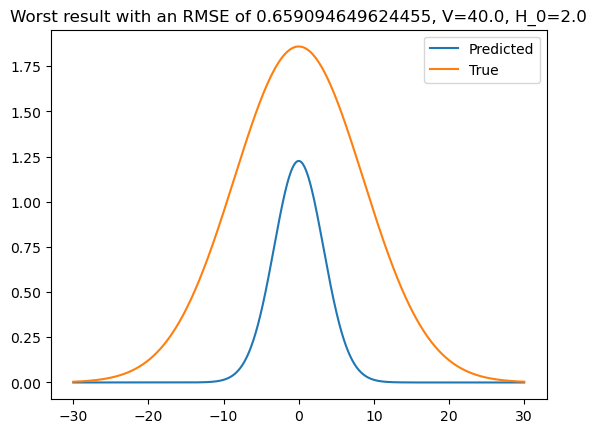

index 43 was the best result with an RMSE of 0.0006066333072724682 for V=2.0 and H_0=4.0


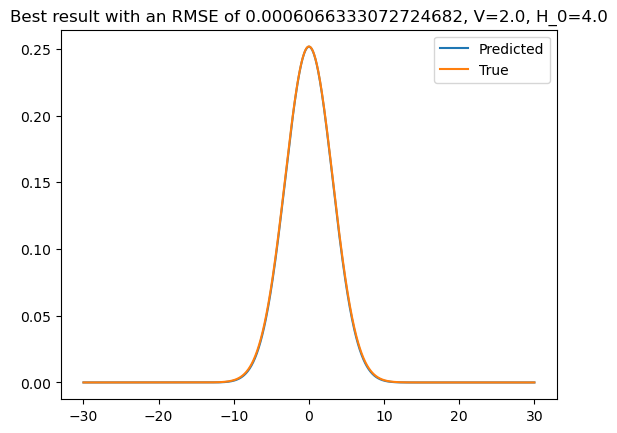

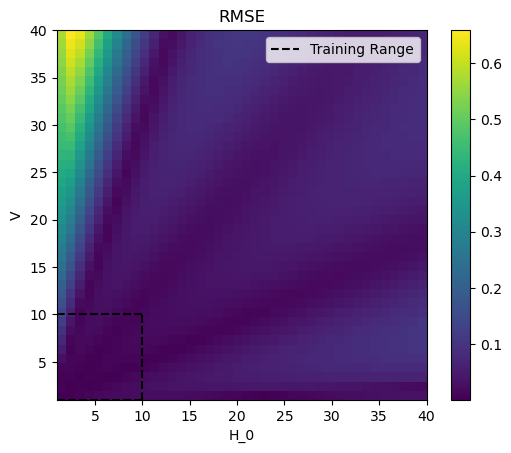

index 1560 was the worst result with an R^2 of -3.7269470413723997 for V=40.0 and H_0=1.0


/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_28961/2731836761.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  worst_index_r2 = int(np.where(r2 == np.min(r2))[0])
/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_28961/2731836761.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_index_r2 = int(np.where(r2 == np.max(r2))[0])


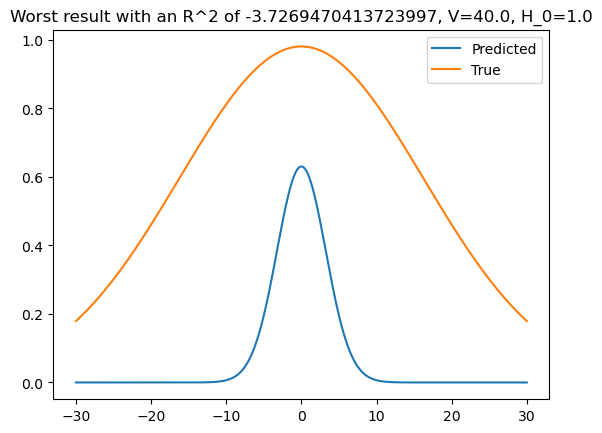

index 43 was the best result with an R^2 of 0.9999236578979032 for V=2.0 and H_0=4.0


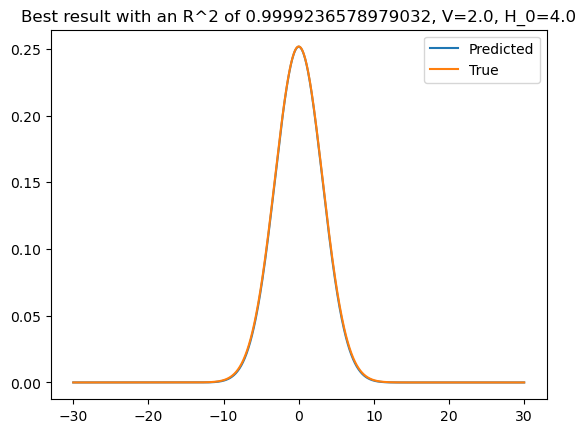

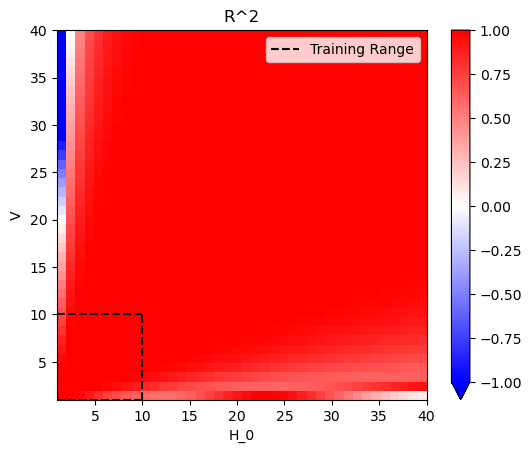

In [62]:
def plot_box(x_coords, y_coords, label=None):
    plt.vlines(x_coords[0], y_coords[0], y_coords[1], color='black', linestyle='--')
    plt.vlines(x_coords[1], y_coords[0], y_coords[1], color='black', linestyle='--')
    plt.hlines(y_coords[0], x_coords[0], x_coords[1], color='black', linestyle='--')
    plt.hlines(y_coords[1], x_coords[0], x_coords[1], color='black', linestyle='--', label=label)

y_test_pred = reg.predict(x_test)

rmse, r2 = reg.test(x_test, y_test)

# RMSE
worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
best_index_rmse = int(np.where(rmse == np.min(rmse))[0])
print(f'index {worst_index_rmse} was the worst result with an RMSE of {rmse[worst_index_rmse]} for V={test_params[worst_index_rmse, 0]} and H_0={test_params[worst_index_rmse, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_rmse, :], label='Predicted')
plt.plot(x, y_test[worst_index_rmse, :], label='True')
plt.legend()
plt.title(f'Worst result with an RMSE of {rmse[worst_index_rmse]}, V={test_params[worst_index_rmse, 0]}, H_0={test_params[worst_index_rmse, 1]}')
plt.show()

print(f'index {best_index_rmse} was the best result with an RMSE of {rmse[best_index_rmse]} for V={test_params[best_index_rmse, 0]} and H_0={test_params[best_index_rmse, 1]}')

plt.figure()
plt.plot(x, y_test_pred[best_index_rmse, :], label='Predicted')
plt.plot(x, y_test[best_index_rmse, :], label='True')
plt.legend()
plt.title(f'Best result with an RMSE of {rmse[best_index_rmse]}, V={test_params[best_index_rmse, 0]}, H_0={test_params[best_index_rmse, 1]}')
plt.show()

rmse_arr = rmse.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
plt.imshow(rmse_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='viridis')
plt.colorbar()
plot_box(H_0_range_train, v_range_train, label='Training Range')
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('RMSE')
plt.legend()
plt.show()

# R2
worst_index_r2 = int(np.where(r2 == np.min(r2))[0])
best_index_r2 = int(np.where(r2 == np.max(r2))[0])
print(f'index {worst_index_r2} was the worst result with an R^2 of {r2[worst_index_r2]} for V={test_params[worst_index_r2, 0]} and H_0={test_params[worst_index_r2, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_r2, :], label='Predicted')
plt.plot(x, y_test[worst_index_r2, :], label='True')
plt.legend()
plt.title(f'Worst result with an R^2 of {r2[worst_index_r2]}, V={test_params[worst_index_r2, 0]}, H_0={test_params[worst_index_r2, 1]}')
plt.show()

print(f'index {best_index_r2} was the best result with an R^2 of {r2[best_index_r2]} for V={test_params[best_index_r2, 0]} and H_0={test_params[best_index_r2, 1]}')

plt.figure()
plt.plot(x, y_test_pred[best_index_r2, :], label='Predicted')
plt.plot(x, y_test[best_index_r2, :], label='True')
plt.legend()
plt.title(f'Best result with an R^2 of {r2[best_index_r2]}, V={test_params[best_index_r2, 0]}, H_0={test_params[best_index_r2, 1]}')
plt.show()

r2_arr = r2.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plt.imshow(r2_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='bwr', norm=divnorm)
plt.colorbar(extend='min')
plot_box(H_0_range_train, v_range_train, label='Training Range')
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('R^2')
plt.legend()
plt.show()